
__This script is useful to visualize the dataset contained in npz files created by using "get_tensors_pre_post.ipynb"__

__Additionally, the script allows you to create subsets of this dataset and save them in npz files__

tensors_pre_[database].npz (useful for segmentation) contains:

- pre-image tensor (height,width,3)
- segmentation mask tensor (height,width,1)

tensors_post_[database].npz (useful for classification) contains:

- post-image tensor (height,width,3)
- classification mask tensor (height,width,1)

, with [database] the name of the database being used 


## Import the necessary libraries

In [1]:

from os import path, walk, makedirs
from sys import exit, stderr

from cv2 import fillPoly, imwrite
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
from skimage.io import imread
from tqdm.auto import tqdm

import numpy as np
import tensorflow as tf

# This removes the massive amount of scikit warnings of "low contrast images"
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import seaborn as sns
import matplotlib.pyplot as plt

/Users/gmeneses/DScourse/00_capstone/Capstone_Building_Damage/notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## __Defining useful functions__


In [2]:
# function to plot images and masks
# argument is a list of masks 
import matplotlib.pyplot as plt

def display(display_list):
    """displays tensors in "display_list" variable
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    plt.figure(figsize=(15, 15))

    
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()

In [3]:
def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building) or un-classified
        1:(255, 255, 255),  # Class 1 - White (no-damage)
        2:(255,255,0),     # Class 2 - Yellow (minor damage)
        3:(255,165,0),     # Class 3 - Orange (major damage)
        4:(255, 0, 0),     # Class 4 - Red (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

## loading tensors pre and post disaster

In [4]:
# pre-disaster

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_pre = np.load('../data/tensors_pre_xBD_last_subset.npz')
images_pre = loaded_arrays_pre['images']
masks_pre = loaded_arrays_pre['masks']
id_pre = loaded_arrays_pre['id']

dis_name = loaded_arrays_pre['disaster_name']
dis_type = loaded_arrays_pre['disaster_type']

In [5]:
# post-disaster

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_post = np.load('../data/tensors_post_xBD_last_subset.npz')
images_post = loaded_arrays_post['images']
masks_post = loaded_arrays_post['masks']
id_post = loaded_arrays_post['id']


In [6]:
print("all disasters contained in this dataset: \n",np.unique(dis_name))

all disasters contained in this dataset: 
 ['guatemala-volcano' 'hurricane-florence' 'hurricane-harvey'
 'hurricane-matthew' 'hurricane-michael' 'mexico-earthquake'
 'midwest-flooding' 'palu-tsunami' 'santa-rosa-wildfire' 'socal-fire']


## Plotting

In [7]:
# range for the number of pair of images
im1 = 0
im2 = images_pre.shape[0]
print("range = ({},{})".format(im1,im2-1))

range = (0,1352)


In [8]:
# to search a particular image
#n_image=list(id_post).index("socal-fire_00001292_post_disaster")

In [9]:
# chose the number of image to inspect
#n_image=453 --> For xBD_last_subset. It has all damage levels

n_image=1

### PRE DISASTER

In [10]:
# PRE DISASTER
# checking size
print("PRE image tensor dimensions: ",images_pre.shape)
print("PRE mask tensor dimensions: ",masks_pre.shape)

print("ID's tensor dimensions: ",id_pre.shape)
print("disaster name tensor dimensions: ",dis_name.shape)
print("disaster type tensor dimensions: ",dis_type.shape)

print("\nCharacteristics image selected:")
print("ID: ",id_pre[n_image])
print("name: ",dis_name[n_image])
print("type: ",dis_type[n_image])



PRE image tensor dimensions:  (1353, 1024, 1024, 3)
PRE mask tensor dimensions:  (1353, 1024, 1024, 1)
ID's tensor dimensions:  (1353,)
disaster name tensor dimensions:  (1353,)
disaster type tensor dimensions:  (1353,)

Characteristics image selected:
ID:  hurricane-harvey_00000513_pre_disaster
name:  hurricane-harvey
type:  flooding


In [11]:
# Looking at selected mask values 
#see pixelwise values that fill the mask number 5 (PRE) 
print(np.unique(masks_pre[n_image, :, :, 0])) # [0 1] --> should be like this for each mask


[0 1]


hurricane-harvey_00000513_pre_disaster


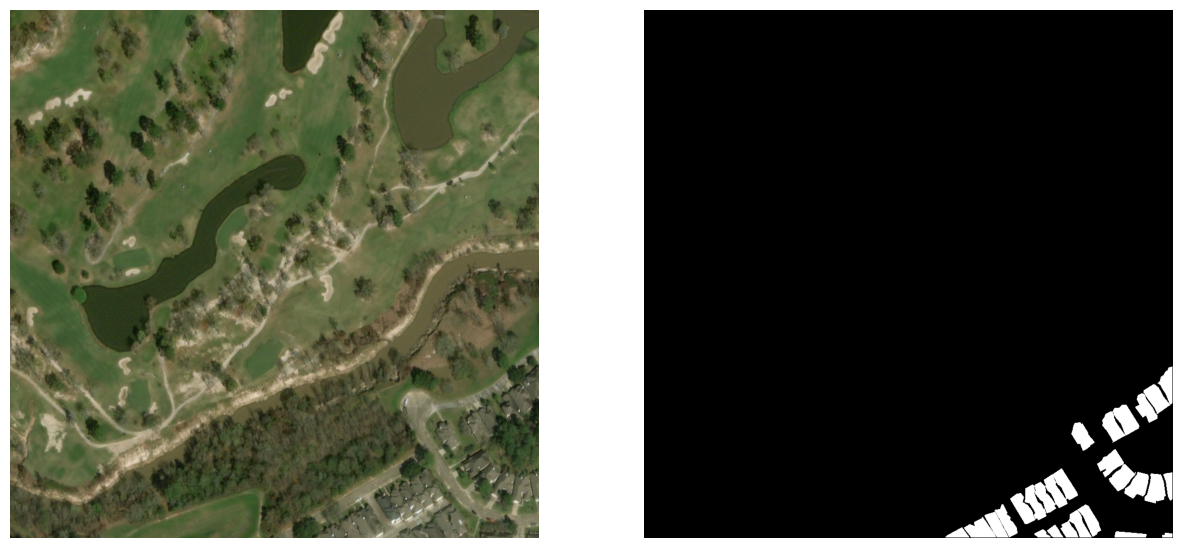

In [12]:
# this is a cell that visualize image and mask for selected image

imagepre = images_pre[n_image, :, :, :]
maskpre = masks_pre[n_image, :, :, 0]
maskpre_deep = convert_mask_to_3_channels(maskpre)
print(id_pre[n_image])
display([imagepre,maskpre_deep]) 

### POST DISASTER

In [13]:
# PRE DISASTER
# checking size
print("POST image tensor dimensions: ",images_pre.shape)
print("POST mask tensor dimensions: ",masks_post.shape)

print("ID's tensor dimensions: ",id_post.shape)
print("disaster name tensor dimensions: ",dis_name.shape)
print("disaster type tensor dimensions: ",dis_type.shape)

print("\nCharacteristics image selected:")
print("ID: ",id_post[n_image])
print("name: ",dis_name[n_image])
print("type: ",dis_type[n_image])

POST image tensor dimensions:  (1353, 1024, 1024, 3)
POST mask tensor dimensions:  (1353, 1024, 1024, 1)
ID's tensor dimensions:  (1353,)
disaster name tensor dimensions:  (1353,)
disaster type tensor dimensions:  (1353,)

Characteristics image selected:
ID:  hurricane-harvey_00000513_post_disaster
name:  hurricane-harvey
type:  flooding


In [14]:
# Looking at selected mask values 
#see pixelwise values that fill the mask number 5 (POST) 
print(np.unique(masks_post[n_image, :, :, 0])) # [0 1 2] --> for n_image= 1. This varies for each mask, depending on damage levels contained


[0 1 2]


hurricane-harvey_00000513_post_disaster


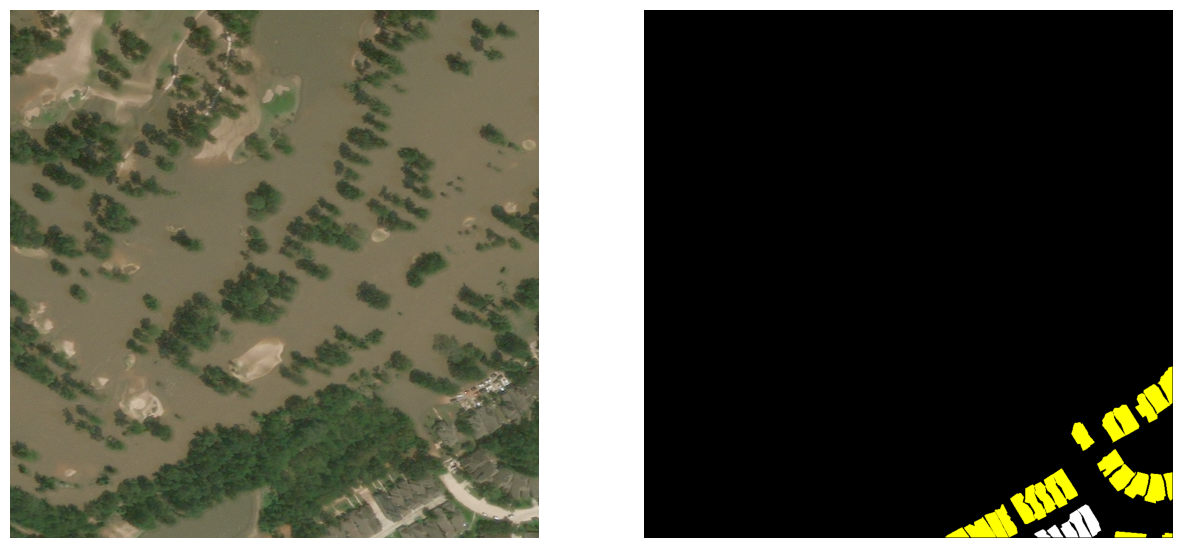

In [15]:
# plot post
imagepost = images_post[n_image, :, :, :]
maskpost = masks_post[n_image, :, :, 0]
maskpost_deep = convert_mask_to_3_channels(maskpost)
print(id_post[n_image])
display([imagepost,maskpost_deep])    

In [16]:
# type of disasters
print(np.unique(dis_type))

['earthquake' 'fire' 'flooding' 'tsunami' 'volcano' 'wind']


In [17]:
# name of different disasters
print(np.unique(dis_name))

['guatemala-volcano' 'hurricane-florence' 'hurricane-harvey'
 'hurricane-matthew' 'hurricane-michael' 'mexico-earthquake'
 'midwest-flooding' 'palu-tsunami' 'santa-rosa-wildfire' 'socal-fire']


In [18]:
# Create a dictionary to count occurrences of each unique disaster_type
disaster_type_counts = {}
for disaster_type in dis_type:
    if disaster_type in disaster_type_counts:
        disaster_type_counts[disaster_type] += 1
    else:
        disaster_type_counts[disaster_type] = 1
disaster_type_counts        

{'flooding': 500,
 'fire': 353,
 'wind': 345,
 'tsunami': 68,
 'earthquake': 75,
 'volcano': 12}

## Create a subset of this dataset

In [19]:
import random

def get_subset_with_homogeneous_distribution(data_loaded, desired_num_samples_per_category):
    '''
    Create images, masks, id's, disaster_name and disaster_type tensors according the variable "desired_num_samples_per_category"
    Args:
        data_loaded (~tensor): npz tensor already loaded
        desired_num_samples_per_category (~int): how many data I want per category (disaster_type)
        
    Returns:
        5 tensors: images, masks, id's, disaster_name and disaster_type.   
    '''
    # Load the data from tensor.npz
    data = data_loaded

    # Extract the disaster_type array
    disaster_type_all = data['disaster_type']

    # Create a dictionary to group indices by disaster_type
    indices_by_disaster_type = {}
    for i, disaster_type in enumerate(disaster_type_all):
        if disaster_type in indices_by_disaster_type:
            indices_by_disaster_type[disaster_type].append(i)
        else:
            indices_by_disaster_type[disaster_type] = [i]

    # Initialize variables to keep track of selected samples
    selected_indices = []

    # Iterate through each disaster_type and randomly select samples
    for disaster_type, indices in indices_by_disaster_type.items():
        num_samples_to_select = min(desired_num_samples_per_category, len(indices))
        selected_samples = random.sample(indices, num_samples_to_select)
        selected_indices.extend(selected_samples)

    # Shuffle the selected indices to mix up the disaster types
    random.shuffle(selected_indices)

    # Use the selected indices to extract the subset of images, masks, and other relevant data
    images_subset = data['images'][selected_indices]
    masks_subset = data['masks'][selected_indices]
    id_subset = data['id'][selected_indices]
    disaster_name_subset = data['disaster_name'][selected_indices]
    disaster_type_subset = data['disaster_type'][selected_indices]

    return images_subset, masks_subset, id_subset, disaster_name_subset, disaster_type_subset

In [20]:
# very small example
desired_num_samples = 2

# obtaining subset
# pre
images_subset_pre, masks_subset_pre, id_subset_pre, disaster_name_subset, disaster_type_subset = get_subset_with_homogeneous_distribution(loaded_arrays_pre, desired_num_samples)
# post
images_subset_post, masks_subset_post, id_subset_post, disaster_name_subset, disaster_type_subset = get_subset_with_homogeneous_distribution(loaded_arrays_post, desired_num_samples)
# name new npz file that stores pre and post subset tensors
database="tensors_pre_xBD_mini"
# save them in npz format
np.savez('tensors_pre_subset_'+database+'.npz', images=images_subset_pre, masks=masks_subset_pre, id=id_subset_pre, disaster_name=disaster_name_subset, disaster_type=disaster_name_subset)
np.savez('tensors_post_subset_'+database+'.npz', images=images_subset_post, masks=masks_subset_post, id=id_subset_post, disaster_name=disaster_name_subset, disaster_type=disaster_name_subset)



## Use the following plot to visualize the distribution of your dataset

In [21]:
disaster_type

'fire'

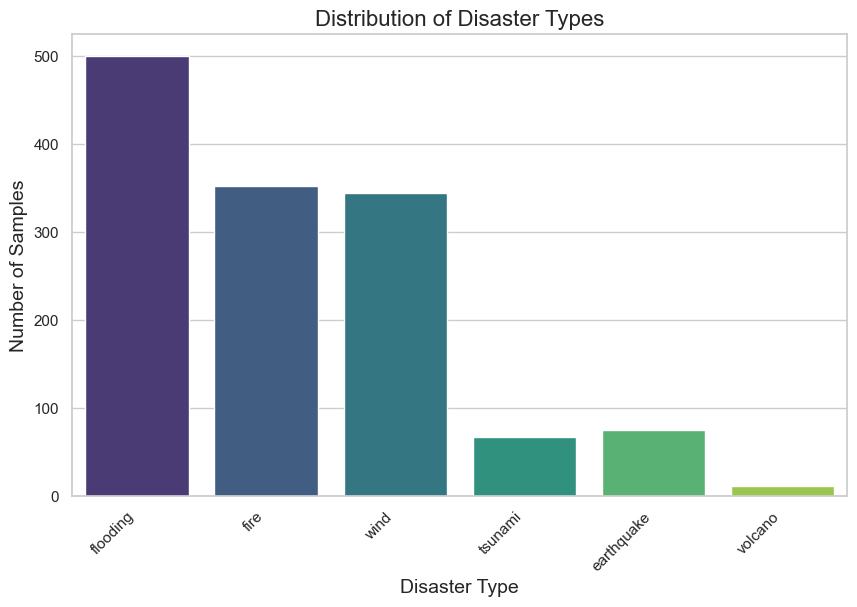

In [24]:
# the whole dataset
type_dataset=dis_type

#the subset just created
#type_dataset=disaster_type_subset

# Create a countplot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=type_dataset, palette="viridis")

# Customize the plot
plt.xlabel("Disaster Type", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Distribution of Disaster Types", fontsize=16)
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()
